In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 95.5 MB/s eta 0:00:00


In [2]:
# !export BERT_BASE_DIR=/content/drive/MyDrive/499 /checkpoints
# !transformers-cli convert --model_type bert \
#   --tf_checkpoint $BERT_BASE_DIR/bert_model.ckpt \
#   --config $BERT_BASE_DIR/bert_config.json \
#   --pytorch_dump_output $BERT_BASE_DIR/pytorch_model.bin

In [3]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
import pandas as pd

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
datapath = '/content/drive/MyDrive/CSE465/one_hot_encoded_issues.csv'
df = pd.read_csv(datapath)
df.head()


,sl,text,aspect,sentiment,Issues,Battery,External,Internal,Screen,Service,Software
0,0,I charge it at night and skip taking the cord ...,cord,0,Battery,1,0,0,0,0,0
1,1,I charge it at night and skip taking the cord ...,battery life,1,Battery,1,0,0,0,0,0
2,2,The tech guy then said the service center does...,service center,-1,Service,0,0,0,0,1,0
3,5,"it is of high quality , has a killer GUI , is ...",quality,1,Service,0,0,0,0,1,0
4,6,"it is of high quality , has a killer GUI , is ...",GUI,1,Screen,0,0,0,1,0,0


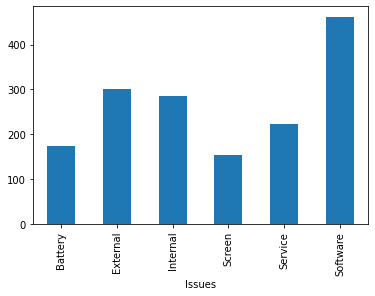

In [7]:
df.groupby(['Issues']).size().plot.bar()

In [8]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")


print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

tensor([[  101,  1045,  2097,  3422,  2033, 23065,  3892,   102,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


In [9]:
example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)

[CLS] i will watch memento tonight [SEP] [PAD] [PAD]


In [10]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['Issues']]

        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 185, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


In [11]:
labels = {"Battery":0,
          "External":1,
          "Internal":2,
          "Screen":3,
          "Service":4,
          "Software":5
          }
# a = [labels[label] for label in df['Issues']]
# print(type(df['Issues'][0]))
# print(type(a[0]))

In [12]:
df1 = df[["text","Issues","sentiment"]]
df1
# Changing Issues labels to numerical value
#"Battery":0,
#"External":1,
#"Internal":2,
#"Screen":3,
#"Service":4,
#"Software":5

# df['Issues'] = [labels[label] for label in df1['Issues']]

,text,Issues,sentiment
0,I charge it at night and skip taking the cord ...,Battery,0
1,I charge it at night and skip taking the cord ...,Battery,1
2,The tech guy then said the service center does...,Service,-1
3,"it is of high quality , has a killer GUI , is ...",Service,1
4,"it is of high quality , has a killer GUI , is ...",Screen,1
...,...,...,...
1594,We also use Paralles so we can run virtual mac...,Software,0
1595,We also use Paralles so we can run virtual mac...,Software,0
1596,We also use Paralles so we can run virtual mac...,Software,0
1597,We also use Paralles so we can run virtual mac...,Software,0


In [13]:
df = df[["text","Issues"]]

In [14]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])
print(len(df_train),len(df_val), len(df_test))

1279 160 160


In [15]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.1):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 6)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [16]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [17]:
torch.cuda.is_available()

True

In [25]:
import torch.optim as optim
from tqdm import tqdm
training_accuracy_history = []
training_loss_history = []
validation_accurary_history = []
validation_loss_history = []
optimizer= None
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            training_accuracy_history.append(total_acc_train / len(train_data))
            training_loss_history.append(total_loss_train / len(train_data))
            validation_accurary_history.append(total_loss_val / len(val_data))
            validation_loss_history.append(total_acc_val / len(val_data))
    return pd.DataFrame({
        "training_accuracy": training_accuracy_history,
        "training loss" : training_loss_history,
        "validation_accuracy": validation_accurary_history,
        "validation_loss": validation_loss_history,
    })    

In [19]:
EPOCHS = 15
model = BertClassifier()
LR = 1e-5

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
df

,text,Issues
0,I charge it at night and skip taking the cord ...,Battery
1,I charge it at night and skip taking the cord ...,Battery
2,The tech guy then said the service center does...,Service
3,"it is of high quality , has a killer GUI , is ...",Service
4,"it is of high quality , has a killer GUI , is ...",Screen
...,...,...
1594,We also use Paralles so we can run virtual mac...,Software
1595,We also use Paralles so we can run virtual mac...,Software
1596,We also use Paralles so we can run virtual mac...,Software
1597,We also use Paralles so we can run virtual mac...,Software


In [21]:
!watch nvidia-smi

>

In [26]:
train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 640/640 [01:05<00:00,  9.81it/s]


Epochs: 1 | Train Loss:  0.392 | Train Accuracy:  0.701 | Val Loss:  0.601 | Val Accuracy:  0.575


100%|██████████| 640/640 [01:03<00:00, 10.11it/s]


Epochs: 2 | Train Loss:  0.343 | Train Accuracy:  0.729 | Val Loss:  0.582 | Val Accuracy:  0.575


100%|██████████| 640/640 [01:03<00:00, 10.14it/s]


Epochs: 3 | Train Loss:  0.315 | Train Accuracy:  0.737 | Val Loss:  0.587 | Val Accuracy:  0.581


100%|██████████| 640/640 [01:03<00:00, 10.14it/s]


Epochs: 4 | Train Loss:  0.294 | Train Accuracy:  0.732 | Val Loss:  0.658 | Val Accuracy:  0.569


100%|██████████| 640/640 [01:03<00:00, 10.10it/s]


Epochs: 5 | Train Loss:  0.276 | Train Accuracy:  0.740 | Val Loss:  0.678 | Val Accuracy:  0.569


100%|██████████| 640/640 [01:03<00:00, 10.14it/s]


Epochs: 6 | Train Loss:  0.266 | Train Accuracy:  0.738 | Val Loss:  0.649 | Val Accuracy:  0.556


100%|██████████| 640/640 [01:03<00:00, 10.12it/s]


Epochs: 7 | Train Loss:  0.256 | Train Accuracy:  0.728 | Val Loss:  0.712 | Val Accuracy:  0.588


100%|██████████| 640/640 [01:03<00:00, 10.15it/s]


Epochs: 8 | Train Loss:  0.248 | Train Accuracy:  0.736 | Val Loss:  0.786 | Val Accuracy:  0.550


100%|██████████| 640/640 [01:03<00:00, 10.15it/s]


Epochs: 9 | Train Loss:  0.243 | Train Accuracy:  0.735 | Val Loss:  0.811 | Val Accuracy:  0.575


100%|██████████| 640/640 [01:03<00:00, 10.11it/s]


Epochs: 10 | Train Loss:  0.244 | Train Accuracy:  0.733 | Val Loss:  0.796 | Val Accuracy:  0.594


100%|██████████| 640/640 [01:03<00:00, 10.13it/s]


Epochs: 11 | Train Loss:  0.240 | Train Accuracy:  0.740 | Val Loss:  0.832 | Val Accuracy:  0.581


100%|██████████| 640/640 [01:03<00:00, 10.12it/s]


Epochs: 12 | Train Loss:  0.164 | Train Accuracy:  0.840 | Val Loss:  0.730 | Val Accuracy:  0.681


100%|██████████| 640/640 [01:03<00:00, 10.12it/s]


Epochs: 13 | Train Loss:  0.128 | Train Accuracy:  0.873 | Val Loss:  0.798 | Val Accuracy:  0.669


100%|██████████| 640/640 [01:03<00:00, 10.08it/s]


Epochs: 14 | Train Loss:  0.124 | Train Accuracy:  0.862 | Val Loss:  0.812 | Val Accuracy:  0.706


100%|██████████| 640/640 [01:03<00:00, 10.10it/s]


Epochs: 15 | Train Loss:  0.115 | Train Accuracy:  0.870 | Val Loss:  0.717 | Val Accuracy:  0.694


,training_accuracy,training loss,validation_accuracy,validation_loss
0,0.700547,0.391778,0.601029,0.57500
1,0.729476,0.343188,0.582079,0.57500
2,0.737295,0.315353,0.586815,0.58125
3,0.731822,0.293922,0.657941,0.56875
4,0.740422,0.276487,0.677924,0.56875
5,0.738077,0.265575,0.649196,0.55625
6,0.727912,0.256129,0.712366,0.58750
7,0.735731,0.247562,0.785998,0.55000
8,0.734949,0.242877,0.811245,0.57500
9,0.733385,0.243704,0.795653,0.59375


In [28]:
a=[1,2,3]
b=[12,3,4]
import pandas as pd
pd.DataFrame({
  "a": a,
  "b": b
})

,a,b
0,1,12
1,2,3
2,3,4


In [29]:
PATH = "/content/drive/MyDrive/499 /Pytorch/model_{}_epoch.pt".format(EPOCHS)
PATH

'/content/drive/MyDrive/499 /Pytorch/model_15_epoch.pt'

In [31]:
torch.save(model, '/content/drive/MyDrive/CSE465/model.pth')

In [32]:
state = {
    'epoch': EPOCHS,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
torch.save(state, "/content/drive/MyDrive/CSE465/model_statedict{}_epoch.pt".format(EPOCHS))

AttributeError: ignored

In [ ]:
# import torch
# a = torch.load('/content/drive/MyDrive/499_all/pth Model/model.pth')

In [ ]:

# torch.save({
#             'epoch': EPOCHS,
#             'model_state_dict': model.state_dict()
#             }, )

In [ ]:
# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# # loss = checkpoint['loss']

In [ ]:
# for i in checkpoint.items():
#   print(checkpoint.get(i))

# model.

In [33]:
trian_history = pd.DataFrame({
        "training_accuracy": training_accuracy_history,
        "training loss" : training_loss_history,
        "validation_accuracy": validation_accurary_history,
        "validation_loss": validation_loss_history,
    })    

In [34]:
trian_history.to_csv("/content/drive/MyDrive/CSE465/training_history.csv")